In [2]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.sql.functions import split as splitsp
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from datetime import datetime
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
%matplotlib inline
import numpy as np
from pyspark.sql.functions import when
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession

from iexfinance.stocks import Stock
from iexfinance.stocks import get_historical_data
import re
import math
import json
import requests
import itertools
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
import string
import holidays
from iexfinance.account import get_metadata
from pyspark.sql.functions import col,lit

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix
import os
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql import Window

In [3]:
spark = SparkSession\
        .builder\
        .appName("NaiveBayesExample")\
        .getOrCreate()

In [4]:
def sandbox(change):
  if change:
    # Set IEX Finance API Token for Sandbox test mode
    os.environ['IEX_API_VERSION'] = 'iexcloud-sandbox'
    os.environ['IEX_TOKEN'] = 'Tsk_32f1a04277394db688e50eecabb4aed4'
  else:
    # Real
    os.environ['IEX_API_VERSION'] = 'stable'
    os.environ['IEX_TOKEN'] = 'sk_2c826f397a344e02a1171a520aaba48f'

def get_start_date(created):
  # 1 day before post date
  us_holidays = holidays.UnitedStates(years = 2021)
  ticker_date = datetime.fromtimestamp(int(created) - 86400).date()

  if ticker_date in us_holidays or ticker_date == datetime(2021, 4, 2).date():
    return False
  if ticker_date.weekday() in [5,6]:
    return False
  
  return ticker_date

'''
Compute growth % of associated stock in a given post.
'''
# computes growth % of given DD
# (today's price <> price at DD's date) = percentage growth from then to now of the stock
def growth(ticker, created):
    if not ticker or ticker == "None":
        return "N/A"
    # get today's date and DD's date (ranges from <>1 week in case of weekends/holidays)
    try:
        # get today's price
        sandbox(False)
        price_today = Stock(ticker).get_quote().latestPrice[ticker]

        ticker_date_start = get_start_date(created)
        ticker_date_end = datetime.fromtimestamp(int(created))

        # dates for post creation: loop until get valid date
        counter = 0
        new_date = created
        while not ticker_date_start and counter < 20:
          counter += 1
          new_date -= 86400
          ticker_date_start = get_start_date(new_date)
        # get DD date's price
        if ticker_date_start:
          # sandbox(True)
          # test = get_historical_data(ticker, ticker_date_start, ticker_date_end, close_only=True).close[0]
          # sandbox(False)
          ticker_date_end = ticker_date_start + timedelta(days=0.8)
          price_ticker_date = get_historical_data(ticker, ticker_date_start, ticker_date_end, close_only=True).close[0]

        # compute percentage growth
        print(ticker,created)
        print(get_metadata())
        percentage = ((price_today / price_ticker_date) - 1) * 100
        return "{:.2f}".format(percentage) + "%"
    except Exception as e:
        print(e)
        return "N/A"
    
sandbox(False)

In [5]:
df = spark.read.csv("Data/100days.csv",header='true')

In [6]:
df.select("growth").where((df.growth!="N/A")).count()

1126

In [9]:
#my_udf = udf(lambda x: int(datetime.timestamp(datetime.strptime(x,"%Y-%m-%d"))))
#df = df.withColumn(colName="timestamp",col = my_udf(df.created))
#df.select("growth").show()
#df.select("timestamp").show()

In [7]:
_df = df.withColumn(colName="testing",col = df.growth)
_df.where((_df.ticker!='None') & (_df.growth=="N/A")).count()
#_df = df.map(lambda x: growth(x.ticker,x.timestamp) if x.ticker!="None" and x.growth=="N/A" else x.growth).collect()

328

In [8]:
_df = _df.rdd.map(lambda x: growth(x.ticker,x.timestamp) if (x.growth=="N/A" and x.ticker!="None") else x.growth).collect()
#_df.select("growth").where(_df.growth!="N/A").count()

In [9]:
_df

['N/A',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 '811.69%',
 'N/A',
 'N/A',
 '811.69%',
 'N/A',
 'N/A',
 '47.13%',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 '775.88%',
 'N/A',
 'N/A',
 'N/A',
 '775.88%',
 'N/A',
 '775.88%',
 '13.52%',
 'N/A',
 'N/A',
 'N/A',
 '-35.30%',
 'N/A',
 '7.29%',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 '795.20%',
 'N/A',
 '-35.30%',
 'N/A',
 'N/A',
 'N/A',
 '-23.07%',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 '795.20%',
 'N/A',
 'N/A',
 '795.20%',
 '795.20%',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 '-35.30%',
 'N/A',
 'N/A',
 'N/A',
 '795.20%',
 '-34.87%',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 '0.72%',
 '-16.54%',
 'N/A',
 '3.11%',
 '-42.70%',
 'N/A',
 'N/A',
 '-7.29%',
 '-7.29%',
 'N/A',
 '694.18%',
 'N/A',
 '694.18%',
 'N/A',
 'N/A',
 'N/A',
 '5.97%',
 'N/A',
 '693.78%',
 '693.78%',
 '19.66%',
 '693.78%',
 '693.78%',
 '693.78%',
 '-36.10%',
 'N/A',
 'N/A',
 '693.78%',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 'N/A',
 '693.78%',
 '693.78%',
 '16.71%',
 '31.15%',
 'N/A',
 '-

In [11]:
b = spark.createDataFrame([(l,) for l in _df], ['newgrowth'])
b.where(b.newgrowth!='N/A').count()

1304

In [12]:
b = spark.createDataFrame([(l,) for l in _df], ['newgrowth'])
b.where(b.newgrowth!='N/A').count()
df = df.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
b = b.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
final_df = df.join(b, df.row_idx == b.row_idx).\
             drop("row_idx")
final_df.select("growth","newgrowth").where(final_df.growth!=final_df.newgrowth).count()
final_df.coalesce(1).write.csv('100days+sandboxedgrowth.csv', header=True)

In [13]:
final_df = df.join(b, df.row_idx == b.row_idx).\
             drop("row_idx")

In [14]:
final_df.select("growth","newgrowth").where(final_df.growth!=final_df.newgrowth).count()
final_df.coalesce(1).write.csv('100days+sandboxedgrowth.csv', header=True)

In [15]:
# $example on$
# Load training data
df = spark.read.csv("Data/fullflairs-40daysredditposts.csv",header='true')
_df = df.withColumn(colName="text_vector",col = splitsp(df.text," "))

#Removing stop words
remover = StopWordsRemover(inputCol="text_vector", outputCol="filtered")
filtered_df = remover.transform(_df)
#i have filtered col


#CountVecotrizing with filtered DF
cv = CountVectorizer(inputCol="filtered",outputCol="features")
cvmodel = cv.fit(filtered_df)
#print(model.vocabulary)
result = cvmodel.transform(filtered_df)

kmeans = KMeans().setK(5).setSeed(10)
model = kmeans.fit(result.select("features"))

predictions = model.transform(result.select("features","Title"))
evaluator = ClusteringEvaluator()
KmeanResult = evaluator.evaluate(predictions)

print(KmeanResult)
# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

0.7165097391084029
Cluster Centers: 
[1.58652095 1.03642987 0.96174863 ... 0.00182149 0.00182149 0.00182149]
[39. 69. 23. ...  0.  0.  0.]
[47. 22.  0. ...  0.  0.  0.]
[2. 2. 1. ... 0. 0. 0.]
[6.15555556 4.71111111 6.04444444 ... 0.         0.         0.        ]


In [295]:
len(cvmodel.vocabulary)

15560

In [296]:
df_features = result.select("features")
np_array = df_features.rdd.map(lambda x : np.array(x.features.toArray())).collect()
np_array = np.array(np_array)
centers = np.array(centers)

from sklearn import decomposition

In [305]:
print(np_array.shape)
Y= [int(row['prediction']) for row in predictions.select("prediction").collect()]

(597, 15560)


(597, 15560)


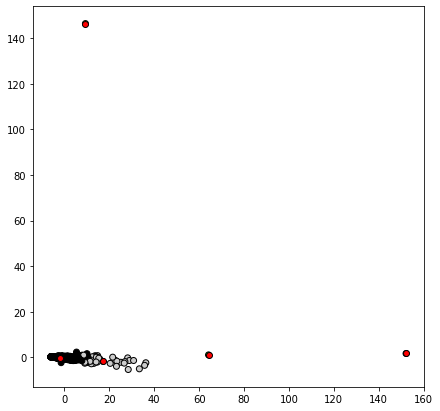

In [306]:
fig = plt.figure(1, figsize=(7, 7))
plt.clf()
ax = fig.add_subplot(1, 1, 1)


plt.cla()
pca = decomposition.PCA(n_components=2)
pca.fit(np_array)
concatenated = pca.transform(np_array)
pca_centers = pca.transform(centers)
print(np_array.shape)

ax.scatter(concatenated[:, 0], concatenated[:, 1],c=Y, cmap=plt.cm.nipy_spectral,
           edgecolor='k')
ax.scatter(pca_centers[:,0],pca_centers[:,1],c="red",cmap=plt.cm.nipy_spectral,
           edgecolor='k')
plt.show()


In [304]:
len(Y)

597

In [299]:
import operator
index1, value1 = max(enumerate(pca.components_[0]), key=operator.itemgetter(1))
index2, value2 = max(enumerate(pca.components_[1]), key=operator.itemgetter(1))
print(cvmodel.vocabulary[index1],cvmodel.vocabulary[index2])
pca.explained_variance_

shares $$b


array([88.24297657, 36.52449149])

In [300]:
cv = CountVectorizer(inputCol="filtered",outputCol="features")
CVmodel = cv.fit(filtered_df)

In [301]:
print(CVmodel.vocabulary[index1],CVmodel.vocabulary[index2])


shares $$b


(597, 15560)


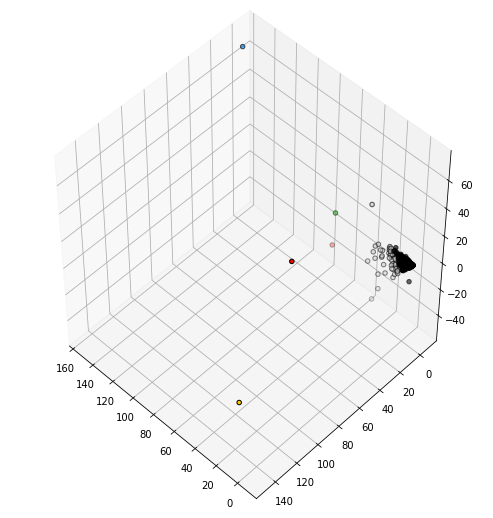

In [307]:
fig = plt.figure(1, figsize=(7, 7))
plt.clf()
plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(np_array)
concatenated = pca.transform(np_array)
pca_centers = pca.transform(centers)
print(np_array.shape)
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
plt.cla()
# Reorder the labels to have colors matching the cluster results
ax.scatter(concatenated[:, 0], concatenated[:, 1], concatenated[:, 2], c=Y, cmap=plt.cm.nipy_spectral,edgecolor='k')
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c="red", cmap=plt.cm.nipy_spectral,
           edgecolor='k')
plt.show()


In [203]:
from sklearn.decomposition import TruncatedSVD

In [338]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, n_iter=10, random_state=42)
svd.fit(np_array)
svd_concatenated = svd.transform(np_array)
from sklearn.manifold import TSNE
TSNE_ = TSNE(n_components=2,learning_rate=300)
X=TSNE_.fit_transform(svd_concatenated)

TruncatedSVD(algorithm='randomized', n_components=50, n_iter=10,
             random_state=42, tol=0.0)

In [339]:
svd_concatenated = svd.transform(np_array)
svd_centers = svd.transform(centers)
svd_concatenated.shape

(597, 50)

In [310]:
from sklearn.manifold import TSNE
TSNE_ = TSNE(n_components=2,learning_rate=300)
X=TSNE_.fit_transform(svd_concatenated)
centers = TSNE_.fit_transform(svd_centers)

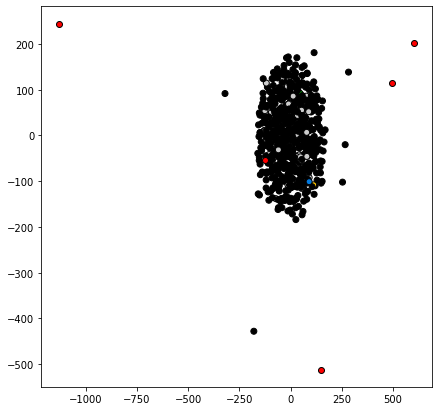

In [311]:
fig = plt.figure(1, figsize=(7, 7))
plt.clf()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(X[:, 0], X[:, 1],c=Y, cmap=plt.cm.nipy_spectral,
           edgecolor='k')
ax.scatter(centers[:,0],centers[:,1],c="red",cmap=plt.cm.nipy_spectral,
           edgecolor='k')
plt.show()

In [343]:
from sklearn.manifold import TSNE


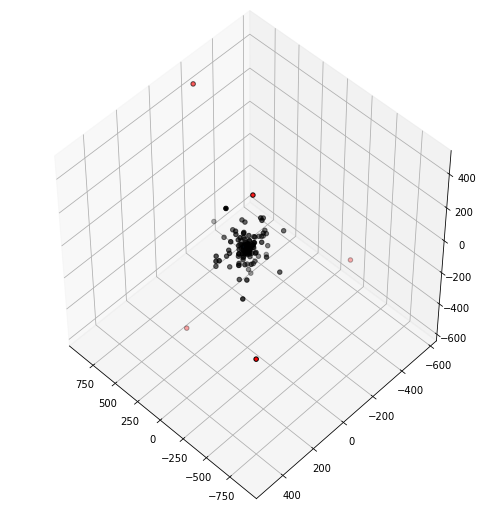

In [350]:
# "n=0
# while n<300:"
TSNE_ = TSNE(n_components=3,learning_rate=300,perplexity=50,n_iter=250)
X=TSNE_.fit_transform(svd_concatenated)
centers = TSNE_.fit_transform(svd_centers)
fig = plt.figure(1, figsize=(7, 7))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
plt.cla()
# Reorder the labels to have colors matching the cluster results
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=Y, cmap=plt.cm.nipy_spectral,edgecolor='k')
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c="red", cmap=plt.cm.nipy_spectral,
           edgecolor='k')
#plt.show()
plt.savefig("Pictures\plot.png")

In [346]:
plt.show()